In [1]:
import pandas as pd
import sklearn.linear_model
import sklearn.svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import os

from datetime import datetime
from html.parser import HTMLParser

In [2]:
def plot_large():
    plt.figure(figsize=(8, 5), dpi=200)

sns.set()

In [3]:
lap_times = pd.read_csv('f1-data/lapTimes.csv')

In [4]:
driver_times = lap_times.groupby([lap_times.raceId, lap_times.driverId, lap_times.lap]).sum()

In [5]:
race_1_drivers = driver_times.loc[(1)].index.get_level_values(0).unique()

In [6]:
for driver in race_1_drivers:
    driver_times.loc[(1, driver)].milliseconds = np.cumsum(driver_times.loc[(1, driver)].milliseconds)

In [7]:
races = pd.read_csv('./f1-data/races.csv')
constructors = pd.read_csv('./f1-data/constructors.csv')
constructor_standings = pd.read_csv('./f1-data/constructorStandings.csv').drop(columns=['Unnamed: 7'])
results = pd.read_csv('f1-data/results.csv')
circuits = pd.read_csv('f1-data/circuits.csv', encoding='ISO-8859-1')

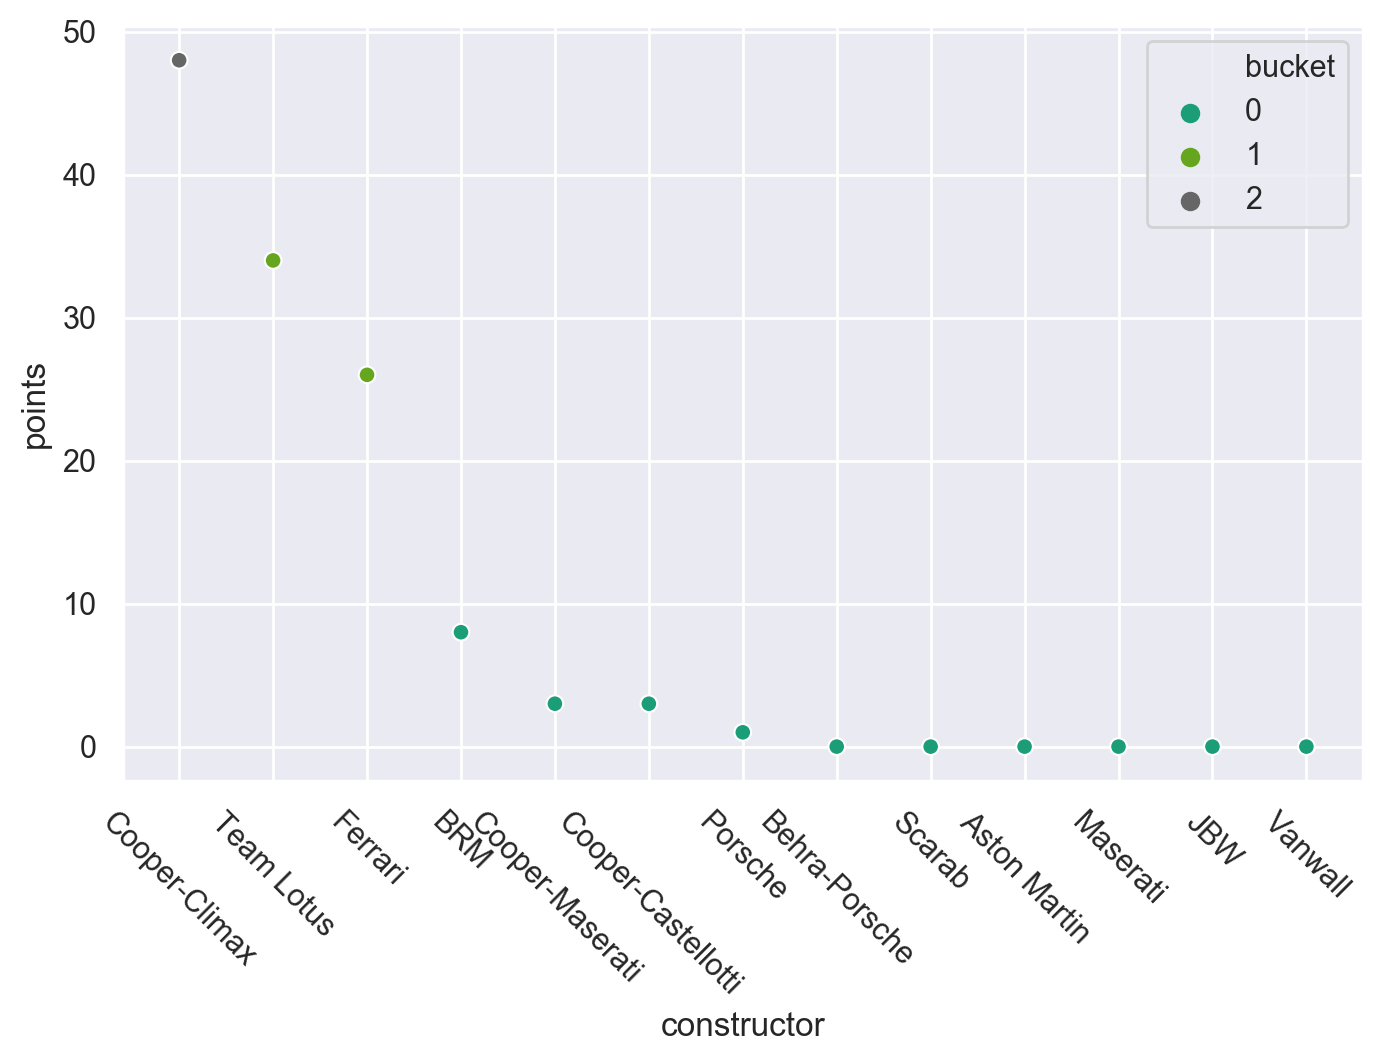

In [8]:
season = 1960

season_races = races[races['year'] == season]
features = constructor_standings[constructor_standings.raceId == season_races.raceId.max()]
features = features[['position', 'points', 'constructorId']]
features['constructor'] = [constructors[constructors.constructorId == x].name.values[0] for x in features['constructorId']]

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit_predict(features[['position', 'points']])
features['bucket'] = kmeans.labels_
features = features.sort_values(by='position')

plot_large()
sns.scatterplot(x='constructor', y='points', hue='bucket', data=features, palette='Dark2')
plt.xticks(rotation=-45);

In [9]:
base_url = 'https://en.wikipedia.org/wiki/{}_Monaco_Grand_Prix'
pole_string = '<a href="/wiki/Pole_position" title="Pole position">Pole position</a>'
fastest_time_start = '<tr><th scope="row" style="width:20%;">Time</th><td colspan="3">'
fastest_time_end = '</td></tr>'
reference_str = '<sup id="cite_ref'
save_path = './f1-data/monacoTimes.csv'

monaco_df = pd.DataFrame(columns=['year', 'lapTimeMillis'])

def datetime_to_millis(dt):
    return (dt.minute * 60 * 1000) + (dt.second * 1000) + (dt.microsecond / 1000)

if os.path.exists(save_path):
    print("Using cached Monaco lap times!")
    monaco_df = pd.read_csv(save_path)
else:
    years = range(1955, 2018)
    parser = HTMLParser()
    print("Downloading data...")
    for year in years:
        print(year, end=", ")
        url = base_url.format(year)
        contents = str(urllib.request.urlopen(url).read())
        pole_index = contents.find(pole_string)
        start_index = contents.find(fastest_time_start, pole_index) + len(fastest_time_start) + 2
        end_index = contents.find(fastest_time_end, start_index)
        time = contents[start_index:end_index]

        if 'reference' in time:
            ref_index = contents.find(reference_str, start_index)
            time = contents[start_index:ref_index]

        if '(aggregate)' in time:
            ref_index = contents.find(' (aggregate)', start_index)
            time = contents[start_index:ref_index]

        try:
            timestamp = datetime.strptime(time, "%M:%S.%f")
        except:
            timestamp = datetime.strptime(time, "%M.%S.%f")
        monaco_df = monaco_df.append({'year': year, 'lapTimeMillis': datetime_to_millis(timestamp)}, ignore_index=True)

    print("DONE!")
    monaco_df.to_csv(save_path)

Using cached Monaco lap times!


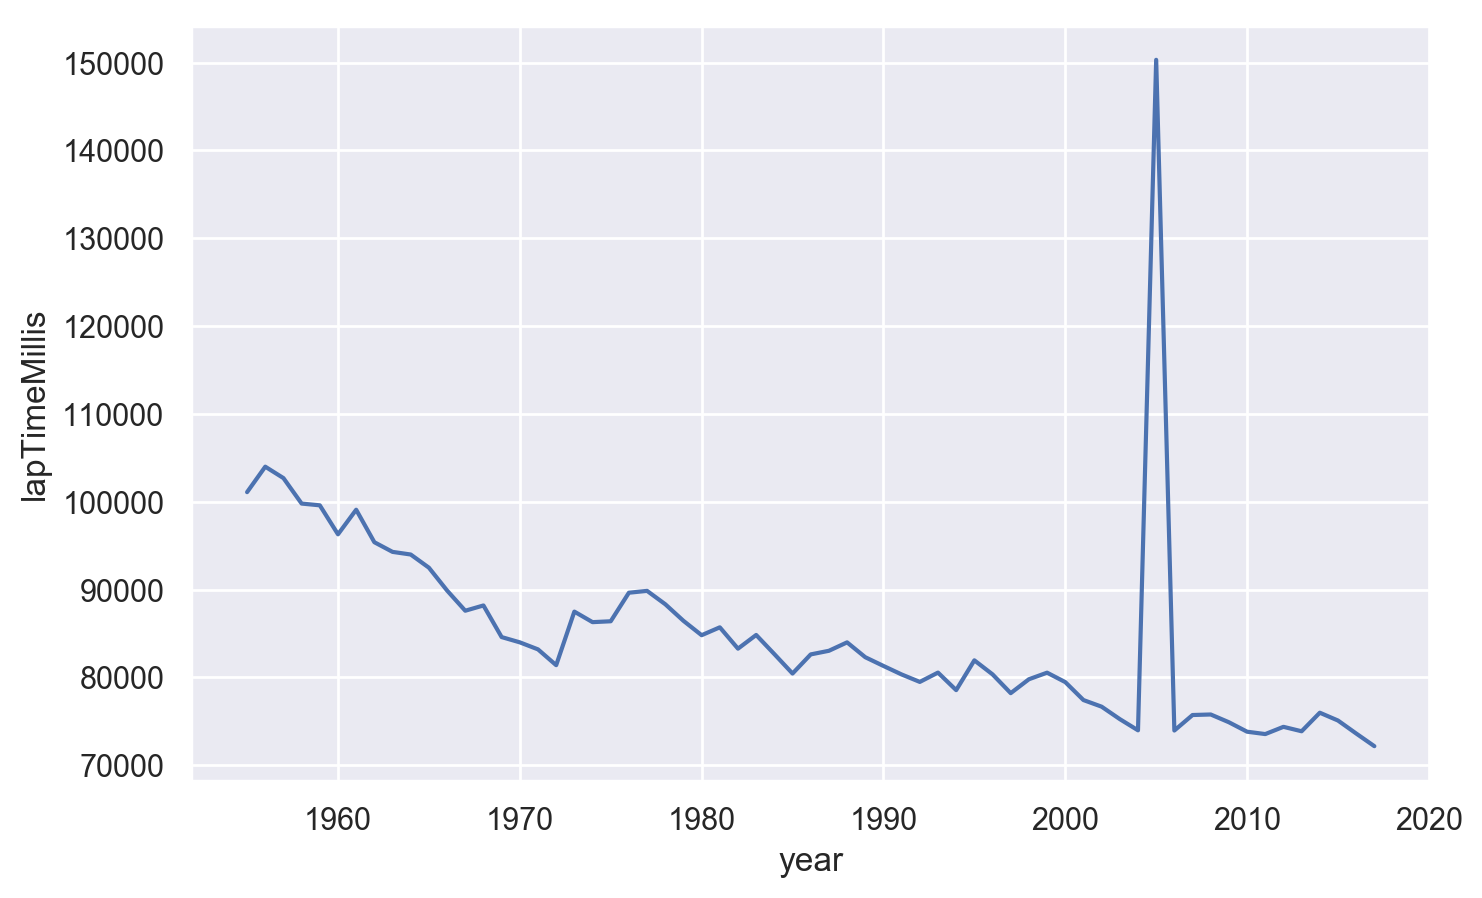

In [10]:
plot_large()
sns.lineplot(x='year', y='lapTimeMillis', data=monaco_df)

## Circuit difficulty
By getting the percentage of drivers who did not finish a race, we can estimate the difficulty of a circuit.

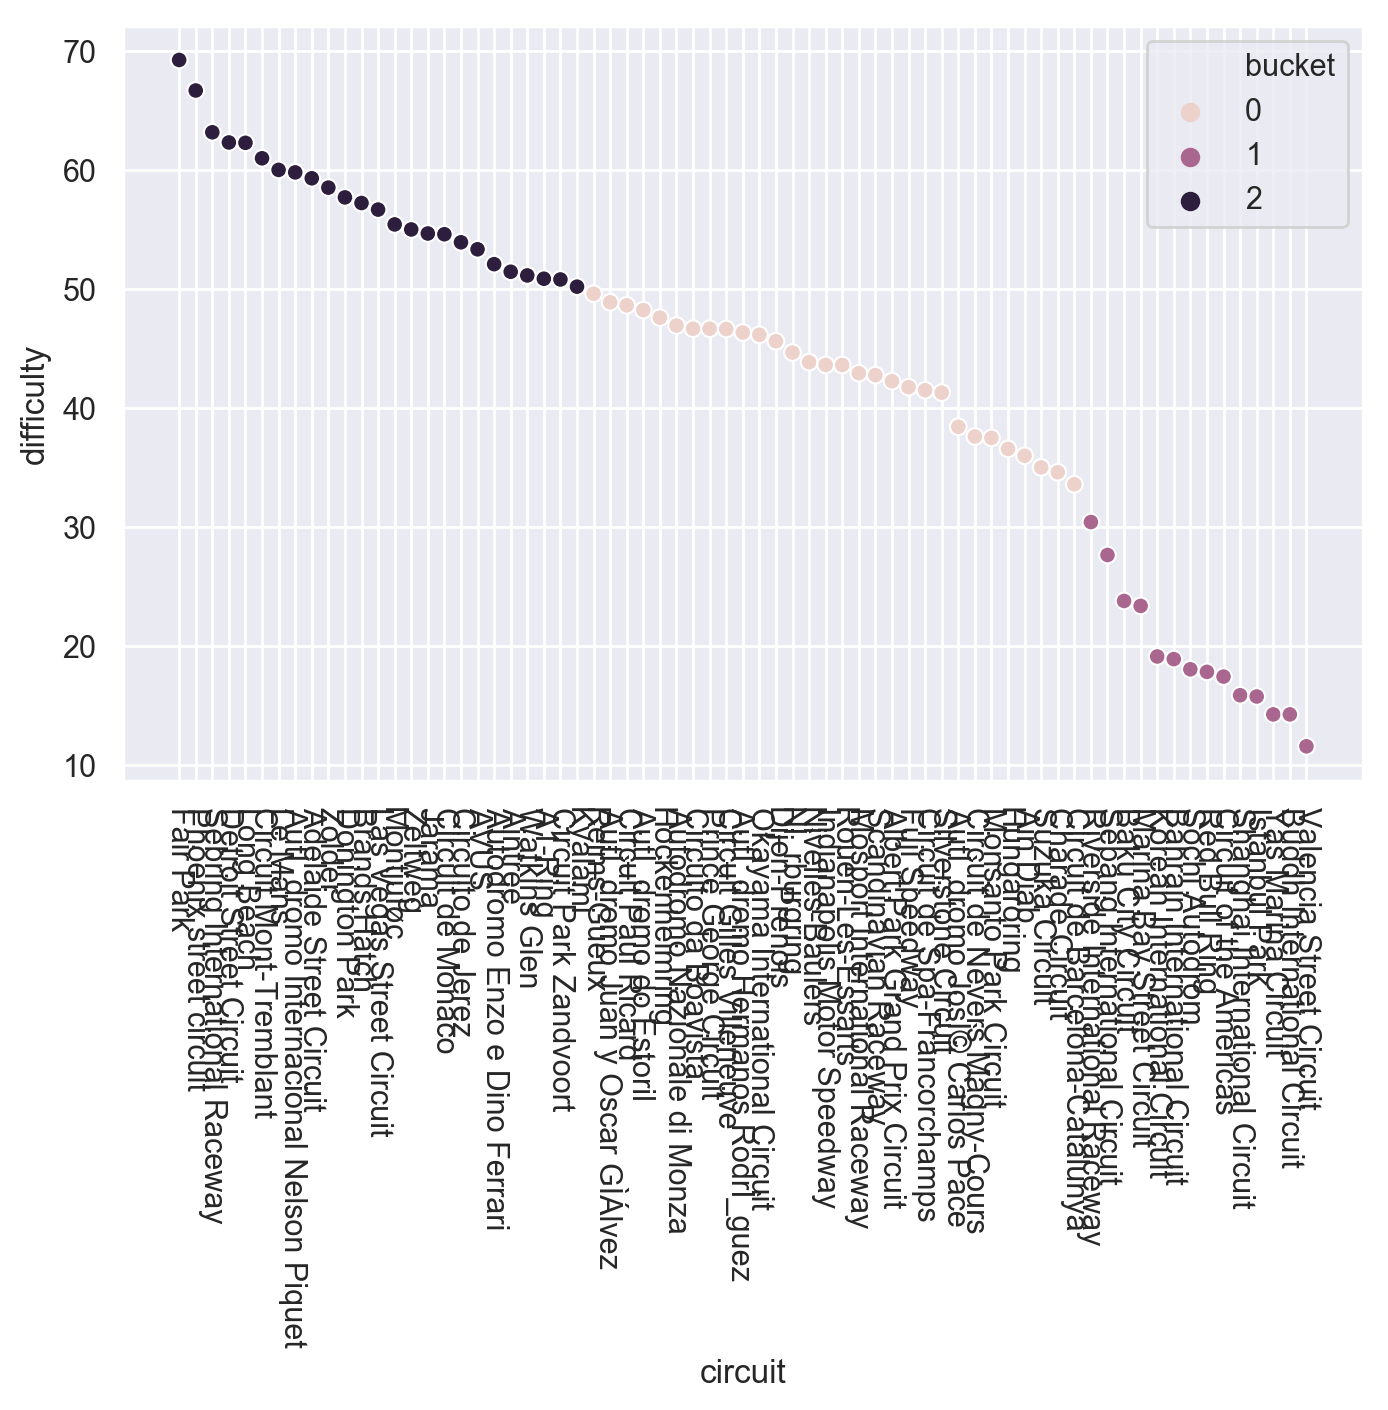

In [12]:
years = range(1958, 2018)

circuits_in_years = races[races.year.isin(years)].circuitId.unique()

circuit_data = {'circuit': [], 'difficulty': []}
for circuitId in circuits_in_years:
    circuit_races = races[races.circuitId == circuitId]
    num_invalid = len(results[(results.raceId.isin(circuit_races.raceId)) & (results.position.isna())])
    total = len(results[(results.raceId.isin(circuit_races.raceId))])
    circuit_name = circuits[circuits.circuitId == circuitId].name.values[0]
    percent_invalid = num_invalid * 100 / total
    circuit_data['circuit'].append(circuit_name)
    circuit_data['difficulty'].append(percent_invalid)

circuit_difficulty_df = pd.DataFrame.from_dict(circuit_data).sort_values(by='difficulty', ascending=False)

kmeans = KMeans(n_clusters=3)
kmeans.fit_predict(circuit_difficulty_df['difficulty'].values.reshape(-1, 1))
circuit_difficulty_df['bucket'] = kmeans.labels_

plot_large()
sns.scatterplot(x='circuit', y='difficulty', hue='bucket', data=circuit_difficulty_df)
plt.xticks(rotation=-90);